import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pylab as plt
from keras.preprocessing import image
from tensorflow.keras import utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
import shutil
import splitfolders
import time

In [28]:
# !unzip /home/jovyan/dataset2/221.zip -d /home/jovyan/dataset2/

# !rm -r /home/jovyan/dataset2/dataset2

print(tf.__version__)

2.12.0


functions

In [4]:
SAVED_MODEL_BEST_ACCURACY_RESULTS = []
SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS = []
SAVED_MODEL_BEST_ACCURACY_RESULTS2 = []
SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS2 = []
IMAGE_SIZE = (64,64)
EPOCHS = 170 # try different # 170 for dataset1

In [5]:
def get_image_and_transform(path):
    data = utils.load_img(path, color_mode='grayscale', target_size=IMAGE_SIZE)
    data = utils.img_to_array(data)
    data = np.expand_dims(data, axis=0)
    # data = data / 255.0
    return data

In [6]:
def build_dataset(dataset_dir): # build 2 datasets for training and testing
    x_train, y_train = [], []
    classes = sorted(os.listdir(dataset_dir))
    for i in range(len(classes)):
        class_dir = os.path.join(dataset_dir, classes[i])
        images = os.listdir(class_dir)
        for image in images:
            full_image_path = os.path.join(class_dir, image)
            if 'ipynb_checkpoints' in full_image_path:
                continue
            x_train.append(get_image_and_transform(full_image_path))
            y_train.append(i)
    return x_train, y_train

In [7]:
def get_examples_and_classes(dataset_dir, num): # return persons' names and persons' ears
    classes = sorted(os.listdir(dataset_dir))
    classes.remove('.ipynb_checkpoints') if '.ipynb_checkpoints' in classes else None
    examples = []
    for i in range(len(classes)):
        class_dir = os.path.join(dataset_dir, classes[i])
        images = os.listdir(class_dir)
        examples.append(os.path.join(class_dir, images[num]))

    return classes, examples

In [8]:
def plot(accuracy, loss, val_accuracy, val_loss): # return schedule of accuracy and loss
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('epoch')

    ax1.set_ylabel('total loss')
    ax1.plot(loss,color='tab:red')
    ax1.plot( val_loss, color='tab:brown')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('accuracy')  
    ax2.plot( accuracy, color='tab:blue')
    ax2.plot( val_accuracy, color='tab:green')
    ax2.tick_params(axis='y')
    fig.tight_layout()

In [101]:
def plot_many(title='title', data=[]): # return schedules of accuracy
    for i,o in enumerate(data):
        plt.figure(i)
        plt.plot([i for i in range(EPOCHS)],o, label=title)
        plt.legend(loc='upper left')

In [102]:
def save_lists(): # save lists of accuracy and loss
    t = time.ctime(time.time())[:-5]
    with open(f'accuracy {t}.txt', 'w') as f:
        for item in SAVED_MODEL_BEST_ACCURACY_RESULTS:
            f.write("%s\n" % item)
    with open(f'val_accuracy {t}.txt', 'w') as f:
        for item in SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS:
            f.write("%s\n" % item)

In [9]:
def read_list_from_file(filename): # read accuracy or loss data  from files
    lst = []
    with open(filename, 'r') as file:
        for line in file.readlines():
            if line in ('', ' ','\n'):
                break
            line = line[1:-2].split(', ')
            lst.append([float(i.strip()) for i in line])
    return lst
# file = 'accuracy Sat May  6 11:19:23.txt'
# l = read_list_from_file(file)
# print("sorted list of max  epochs' values for accuracy  ", show_best_res(l))

In [10]:
def show_best_res(list_of_data): # return max value in every list of accuracy
    max_val = {}
    for i, o in enumerate(list_of_data):
        max_val[i] = max(o)
    return dict(sorted(max_val.items(), key=lambda item: item[1], reverse=True))

In [105]:
def create_new_dataset(path):
    images = sorted(os.listdir(path))
    for image in images:
        if 'ipynb_checkpoints' in image:
            continue
        old_path = path + '/' + image
        new_path = f"/home/jovyan/dataset2/dataset2/{image[:3]}"

        if os.path.exists(new_path):
            shutil.copyfile(old_path, new_path+'/'+image)
        else:
            os.mkdir(new_path)
            shutil.copyfile(old_path, new_path+'/'+image)

dataset

In [30]:
train_folder = "/home/jovyan/dataset1/dataset2/train"
test_folder = "/home/jovyan/dataset1/dataset2/test"

In [47]:
image = "/home/jovyan/dataset1/dataset2/test/001.ALI_HD/001 (14).jpg"
image = utils.load_img(image)
image.size

(74, 122)

In [24]:
# data_folder = "/home/jovyan/work/ear/raw"
# create_new_dataset(data_folder)
# train_datagen = "/home/jovyan/dataset2/dataset2"
# splitfolders.ratio(train_datagen, output="/home/jovyan/dataset2/dirty_set", seed=1337, ratio=(.7, 0.3)) 
# train_folder = "/home/jovyan/dataset2/train"
# test_folder = "/home/jovyan/dataset2/test"

In [31]:
train_datagen = ImageDataGenerator(rescale = 1./255)#, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 color_mode='grayscale')

test_set = test_datagen.flow_from_directory(test_folder,
                                            target_size = IMAGE_SIZE,
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            color_mode='grayscale')



# print(training_set.filepaths)
# print(training_set.classes)
# print(training_set.class_indices)


Found 22736 images belonging to 164 classes.
Found 5684 images belonging to 164 classes.


model

In [12]:
def model(in_1=32, in_2=32, in_3=32, in_4=64):
    model = Sequential()
    model.add(Conv2D(filters=in_1,kernel_size=3, strides=1, input_shape=(64,64,1), padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=in_2,kernel_size=3, strides=1, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=in_3,kernel_size=3, strides=1, padding ='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())
    
    
    model.add(Conv2D(filters=in_4,kernel_size=3, strides=1, padding ='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(units = 512 , activation = 'tanh')) # try delete
    model.add(Dense(units = 164 , activation = 'softmax'))

    model.compile( optimizer='Adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

    return model
summary_example = model()
summary_example.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

choose best hyperparameters

In [83]:
def model_and_best_hyperparameters(nums):
    start_time1 = time.time() 
    for i in nums:
        start_time2 = time.time()
        
        ready_model = model(i,i,i,i)        # change order 
        trained_model = ready_model.fit(training_set, steps_per_epoch = 32, epochs = EPOCHS,
                                        validation_data = test_set, validation_steps=16)
        
        print("for one training time taken: {:.2f} seconds".format(time.time() - start_time2)) # how much time one training take

        SAVED_MODEL_BEST_ACCURACY_RESULTS.append(trained_model.history['accuracy'])
        SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS.append(trained_model.history['val_accuracy'])
        
    return time.time() - start_time1 # how much time all training take

In [84]:
all_time = model_and_best_hyperparameters([32])

Epoch 1/170


2023-05-30 13:06:22.407939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


128/128 [==============================] - ETA: 0s - loss: 5.1421 - accuracy: 0.0225

2023-05-30 13:06:39.373533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


128/128 [==============================] - 18s 131ms/step - loss: 5.1421 - accuracy: 0.0225 - val_loss: 5.5038 - val_accuracy: 0.0088
Epoch 2/170
128/128 [==============================] - 17s 135ms/step - loss: 4.6404 - accuracy: 0.0615 - val_loss: 5.5600 - val_accuracy: 0.0068
Epoch 3/170
128/128 [==============================] - 15s 114ms/step - loss: 4.3196 - accuracy: 0.0913 - val_loss: 5.2994 - val_accuracy: 0.0137
Epoch 4/170
128/128 [==============================] - 14s 113ms/step - loss: 4.0022 - accuracy: 0.1377 - val_loss: 5.2244 - val_accuracy: 0.0342
Epoch 5/170
128/128 [==============================] - 15s 118ms/step - loss: 3.7748 - accuracy: 0.1726 - val_loss: 4.3319 - val_accuracy: 0.1025
Epoch 6/170
128/128 [==============================] - 21s 163ms/step - loss: 3.4965 - accuracy: 0.2225 - val_loss: 4.0543 - val_accuracy: 0.1299
Epoch 7/170
128/128 [==============================] - 16s 124ms/step - loss: 3.2310 - accuracy: 0.2734 - val_loss: 4.3004 - val_accurac

In [85]:
print("sorted list of max  epochs' values for accuracy  ", show_best_res(SAVED_MODEL_BEST_ACCURACY_RESULTS))
print("sorted list of max  epochs' values for val_accuracy  ", show_best_res(SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS))
print('all training take {:.2f} minutes'.format(all_time/60))
# save_lists()  

sorted list of max  epochs' values for accuracy   {0: 0.983642578125}
sorted list of max  epochs' values for val_accuracy   {0: 0.4033203125}
all training take 43.71 minutes


train and save model

In [78]:
def final_model():
    ready_model = model(64,64,64,64)
    call_back = ModelCheckpoint(f"/home/jovyan/weights.hdf5", monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
    trained_model = ready_model.fit(training_set, steps_per_epoch = 32 , epochs = EPOCHS, #len(training_set)
                                    validation_data = test_set, validation_steps=16 , callbacks = [call_back]) #len(test_set)
    
    SAVED_MODEL_BEST_ACCURACY_RESULTS2.append(trained_model.history['accuracy'])
    SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS2.append(trained_model.history['val_accuracy'])
    return trained_model, ready_model


In [79]:
history, trained_model = final_model()

Epoch 1/170


2023-05-30 12:17:40.245783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - ETA: 0s - loss: 5.3815 - accuracy: 0.0137

2023-05-30 12:17:48.082521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 9s 227ms/step - loss: 5.3815 - accuracy: 0.0137 - val_loss: 5.2278 - val_accuracy: 0.0039
Epoch 2/170
32/32 [==============================] - 7s 213ms/step - loss: 5.2431 - accuracy: 0.0264 - val_loss: 5.5913 - val_accuracy: 0.0117
Epoch 3/170
32/32 [==============================] - 7s 218ms/step - loss: 5.0257 - accuracy: 0.0244 - val_loss: 6.0878 - val_accuracy: 0.0039
Epoch 4/170
32/32 [==============================] - 7s 212ms/step - loss: 4.9351 - accuracy: 0.0361 - val_loss: 5.7156 - val_accuracy: 0.0000e+00
Epoch 5/170
32/32 [==============================] - 7s 212ms/step - loss: 4.8351 - accuracy: 0.0498 - val_loss: 5.7029 - val_accuracy: 0.0000e+00
Epoch 6/170
32/32 [==============================] - 7s 216ms/step - loss: 4.8171 - accuracy: 0.0469 - val_loss: 5.9195 - val_accuracy: 0.0117
Epoch 7/170
32/32 [==============================] - 7s 213ms/step - loss: 4.6028 - accuracy: 0.0645 - val_loss: 6.0446 - val_accuracy: 0.0156
Epo

plot model

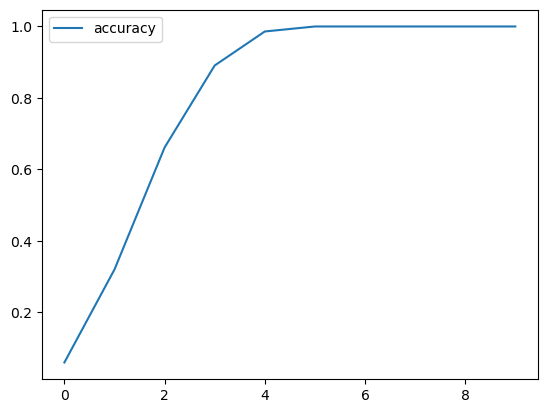

In [ ]:
# plot_many('accuracy', SAVED_MODEL_BEST_ACCURACY_RESULTS)

sorted list of max  epochs' values for accuracy   {0: 0.955078125}
sorted list of max  epochs' values for val_accuracy   {0: 0.47265625}


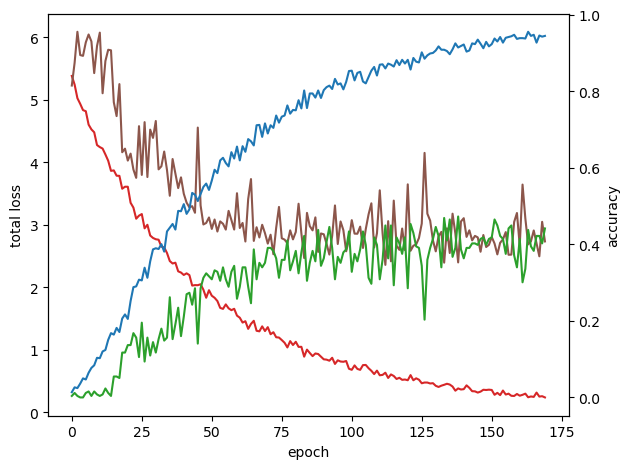

In [80]:
if trained_model:
    print("sorted list of max  epochs' values for accuracy  ", show_best_res(SAVED_MODEL_BEST_ACCURACY_RESULTS2))
    print("sorted list of max  epochs' values for val_accuracy  ", show_best_res(SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS2))
    plot(history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss'])
    # save_lists() #val accuracy 0.480

predict

In [13]:
predict_model = Sequential()
ready_model2 = model(32,64,64,32)
for layer in ready_model2.layers[:-1]:
    predict_model.add(layer)
predict_model.add(Dense(units=1, activation=None))
predict_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
predict_model.summary()


predict_model.load_weights('weights.hdf5', skip_mismatch=True, by_name=True)

# # Load weights and biases from model manually
# for i in range(len(predict_model.layers) - 1):
#     predict_model.layers[i].set_weights(model.layers[i].get_weights())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                      

In [14]:
def distance_metric(x1, x2):
    return tf.sqrt(tf.reduce_sum(tf.square(x1 - x2), axis=1))

def predict(model, known_data_path, unknown_data_path):
    known_data = get_image_and_transform(known_data_path)
    unknown_data = get_image_and_transform(unknown_data_path)

    known_data = model.predict(known_data)
    unknown_data = model.predict(unknown_data)
    distance = distance_metric(unknown_data, known_data)

    threshold = 1
    return  bool(distance < threshold), float(distance[0])

predict(predict_model, '/home/jovyan/22.jpg', '/home/jovyan/11.jpg')

1/1 [==============================] - 0s 16ms/step


(True, 0.32555246353149414)

choose best threshold

In [21]:
def return_lists_of_classes_and_images():
    test_folder = "/home/jovyan/dataset1/dataset2/test"
    classes, examples1 = get_examples_and_classes(test_folder,1) # every first image
    classes, examples2 = get_examples_and_classes(test_folder,2) #every second image
    examples3 = examples2[:len(examples2)//2]
    examples3 += examples2[len(examples2)//2::-1] # second part of list is reversed second part of examples2 list
    colors = ['blue' for i in range(len(examples2)//2)] + ['red' for i in range(len(examples2)//2)]
    del examples2
    return classes, examples1, examples3, colors

def find_threshold():
    classes, examples1, examples3, colors = return_lists_of_classes_and_images()

    y_predict_tensors = []
    y_predict_labels = []
    for i in range(len(examples1)):  # try build histogram
        predict_label, predict_tensor = predict(predict_model, examples1[i], examples3[i])
        y_predict_tensors.append(predict_tensor) # distance list
        y_predict_labels.append(int(predict_label)) # bool list
    
    true_labels = [1 for i in range(len(examples3)//2)] + [0 for i in range(len(examples3)//2)]
    return y_predict_tensors, y_predict_labels, true_labels, colors

In [22]:
y_predict_tensors, y_predict_labels, true_labels, colors = find_threshold()

1/1 [==============================] - 0s 16ms/step


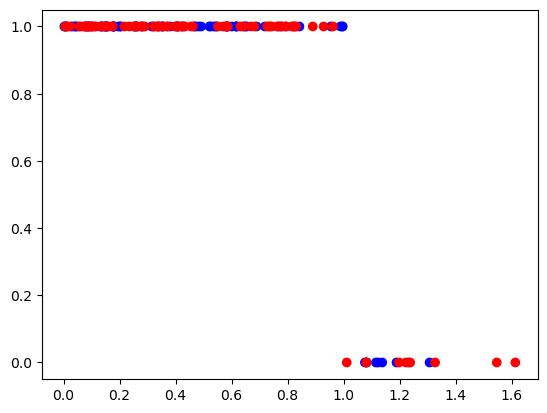

In [25]:
plt.scatter(y_predict_tensors, y_predict_labels, c=colors)
plt.show()

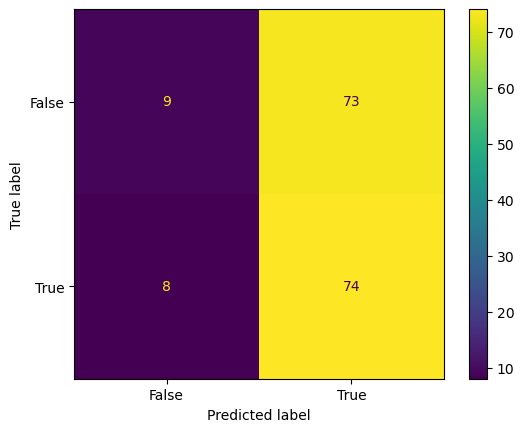

In [27]:
confusion_matrix = confusion_matrix(true_labels, y_predict_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()